In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Перш за все прочитаэмо датасет
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.fashion_mnist.load_data()

# Нормалізуємо
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

# Розділимо тестові дані на тест та валідацію
test_X, valid_X, test_Y, valid_Y = train_test_split(test_X, test_Y, test_size=0.5, shuffle=True, stratify=test_Y)

# Приведемо категорії у вигляд, необхідний для роботи метрики
train_Y = tf.one_hot(train_Y, 10)
test_Y = tf.one_hot(test_Y, 10)
valid_Y = tf.one_hot(valid_Y, 10)

train_X.shape, train_Y.shape, test_X.shape, test_Y.shape, valid_X.shape, valid_Y.shape

((60000, 28, 28),
 TensorShape([60000, 10]),
 (5000, 28, 28),
 TensorShape([5000, 10]),
 (5000, 28, 28),
 TensorShape([5000, 10]))

In [3]:
# Створимо функцію, для швидкого виведення історії втрат та точності
def present_histiry(title, history_data):
    figure, axis = plt.subplots(ncols=2, figsize=(15,10))

    axis[0].plot(history_data.history["loss"], label="train loss")
    axis[0].plot(history_data.history["val_loss"], label="valid loss")
    # axis[0].title(title + ": loss")
    axis[0].grid()
    axis[0].legend()
    #plt.show()

    axis[1].plot(history_data.history["categorical_accuracy"], label="train accuracy")
    axis[1].plot(history_data.history["val_categorical_accuracy"], label="valid accuracy")
    # axis[1].title(title + ": accuracy")
    axis[1].grid()
    axis[1].legend()

    figure.suptitle(title + f" max val accuracy {max(history_data.history['val_categorical_accuracy'])}")
    
    plt.show()

In [4]:
conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False # Заморозимо

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Все добре, лише зображення чорнобіле (1 канал) і має замалий розмір (28 * 28 замість мінімально очікуваного 32 * 32)

Для підготовки даних створимо модель

In [5]:
pre_model = tf.keras.models.Sequential()

pre_model.add(tf.keras.layers.Input((28, 28)))
pre_model.add(tf.keras.layers.Reshape((1, 28, 28, 1)))
pre_model.add(tf.keras.layers.ZeroPadding3D((2, 2, 1), data_format="channels_first"))
pre_model.add(tf.keras.layers.Reshape((32, 32, 3)))

pre_model.summary()

pre_model.compile()
#pre_model.build(input_shape=(28, 28, ))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 28, 28, 1)      0         
                                                                 
 zero_padding3d (ZeroPaddin  (None, 1, 32, 32, 3)      0         
 g3D)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
pre_model.input.shape

TensorShape([None, 28, 28])

In [7]:
res = pre_model.predict(test_X)

157/157 [==============================] - 0s 2ms/step


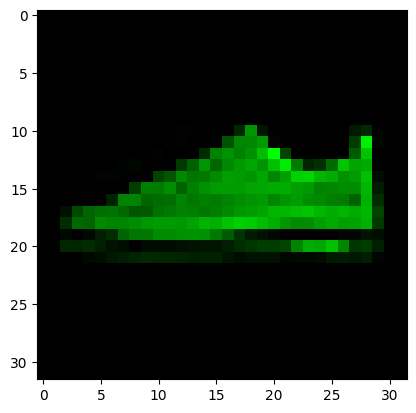

In [8]:
plt.imshow(res[0])


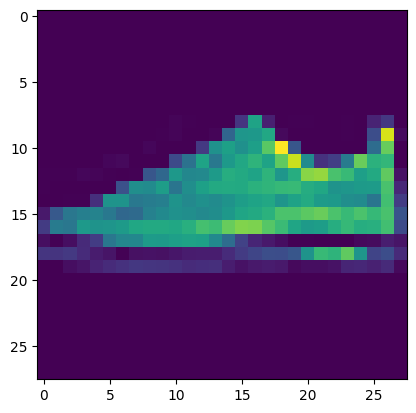

In [9]:
plt.imshow(test_X[0])

Отже, зображення до вимог підігнали, щоправда, все у нам буде зелене (адже в RGB-схемі червоний та блакитний канали пусті).

Тепер ми можемо зібрати повну модель, або ж опрацювати вхідні дані створеною моделлю та VGG16 і подати їх на вхід до нашої моделі на етапі навчання. В другому випадку ми зекономимо багато часу на навчанні, адже за кожної епохи нам не треба буде постійно проганяти дані через препроцесинг.

In [10]:
train_X_pre = pre_model.predict(train_X)
test_X_pre = pre_model.predict(test_X)
valid_X_pre = pre_model.predict(valid_X)

157/157 [==============================] - 0s 3ms/step


In [11]:
train_X_vgg16 = conv_base.predict(train_X_pre)

1875/1875 [==============================] - 309s 165ms/step


In [12]:
test_X_vgg16 = conv_base.predict(test_X_pre)

157/157 [==============================] - 24s 152ms/step


In [13]:
valid_X_vgg16 = conv_base.predict(valid_X_pre)

157/157 [==============================] - 23s 147ms/step


In [14]:
train_X_vgg16.shape

(60000, 1, 1, 512)

In [15]:
d_model = tf.keras.models.Sequential()

d_model.add(tf.keras.layers.Input((1, 1, 512)))
d_model.add(tf.keras.layers.Flatten())
d_model.add(tf.keras.layers.Dense(128, activation="relu"))
d_model.add(tf.keras.layers.GaussianNoise(.2))
d_model.add(tf.keras.layers.Dense(10, activation="softmax"))

d_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 gaussian_noise (GaussianNo  (None, 128)               0         
 ise)                                                            
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 66954 (261.54 KB)
Trainable params: 66954 (261.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
d_model.compile(optimizer=tf.keras.optimizers.AdamW(), metrics=['categorical_accuracy', 'accuracy', 'categorical_crossentropy'], loss=tf.keras.losses.categorical_crossentropy)

In [17]:
model_id = "d"
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=0, patience=20)
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_{model_id}", save_best_only=True, monitor="val_accuracy", mode="max", verbose=0)

history = d_model.fit(train_X_vgg16, train_Y, batch_size=1000, epochs=200, verbose=0, validation_data=(valid_X_vgg16, valid_Y), callbacks=[callback_save, callback_early_stopping])

INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


INFO:tensorflow:Assets written to: model_d\assets


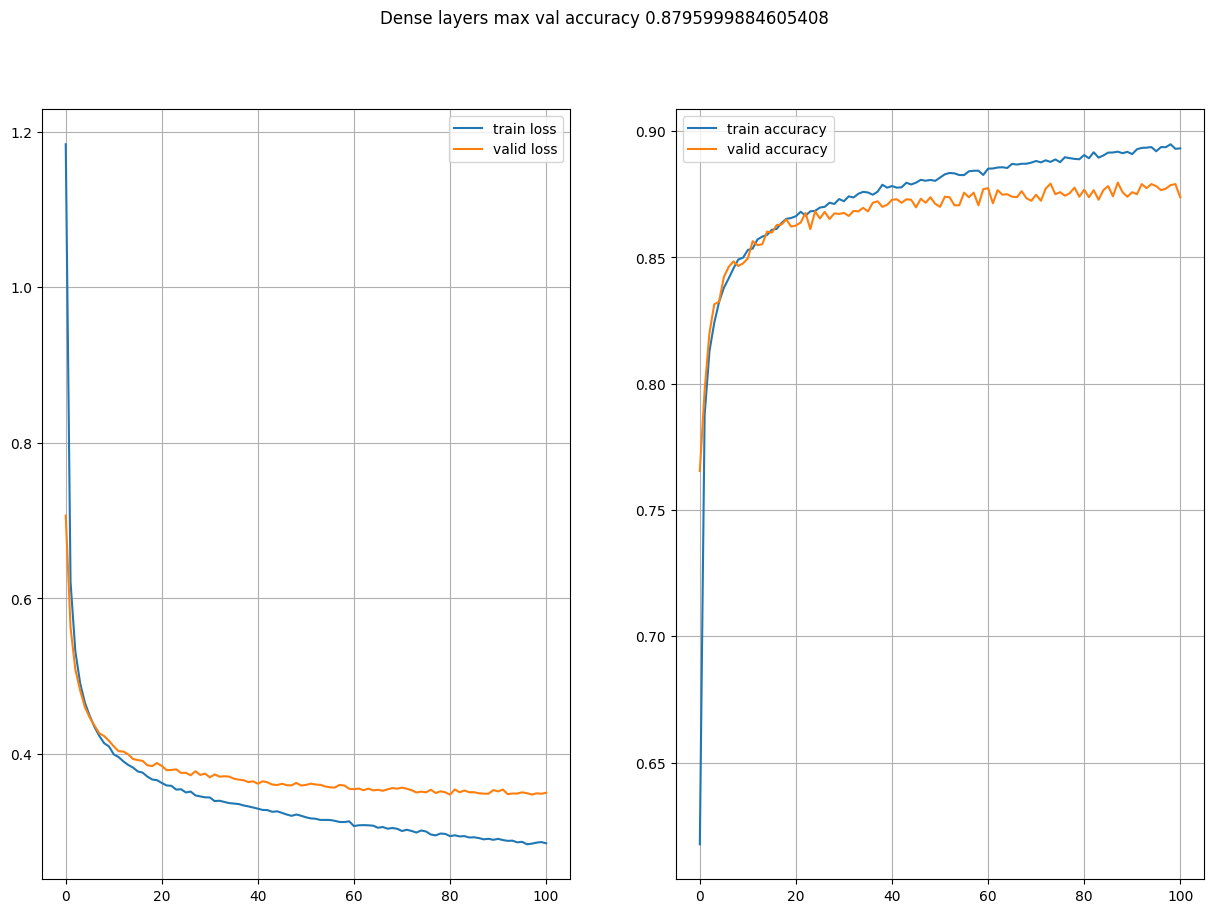

In [18]:
present_histiry("Dense layers", history)

Швидкість навчання чудова, а от результат бідовий.

Згадуємо, що VGG16 хоче кольорові зображення, а у нас всього 1 канал. Спробуємо переграти препроцесинг таким чином, щоб у нас було хоча б чесне чорно-біле зображення з трьома каналами, а не тільки зеленим

In [62]:
pre_model_2 = tf.keras.models.Sequential()

pre_model_2.add(tf.keras.layers.Input((28, 28)))
pre_model_2.add(tf.keras.layers.Reshape((1, 28, 28, 1)))
pre_model_2.add(tf.keras.layers.ZeroPadding3D((2, 2, 0), data_format="channels_first"))
pre_model_2.add(tf.keras.layers.UpSampling3D(size=(1, 1, 3), data_format="channels_first"))
pre_model_2.add(tf.keras.layers.Reshape((32, 32, 3)))

pre_model_2.summary()

pre_model_2.compile()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 1, 28, 28, 1)      0         
                                                                 
 zero_padding3d_5 (ZeroPadd  (None, 1, 32, 32, 1)      0         
 ing3D)                                                          
                                                                 
 up_sampling3d_3 (UpSamplin  (None, 1, 32, 32, 3)      0         
 g3D)                                                            
                                                                 
 reshape_7 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
res2 = pre_model_2.predict(test_X)

157/157 [==============================] - 0s 2ms/step


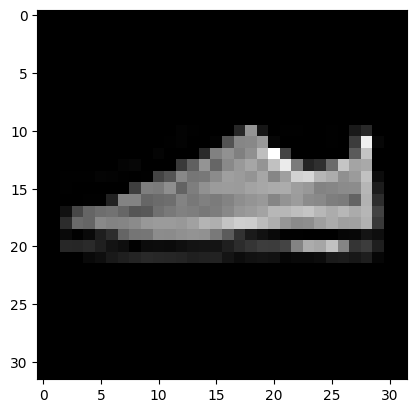

In [65]:
plt.imshow(res2[0])

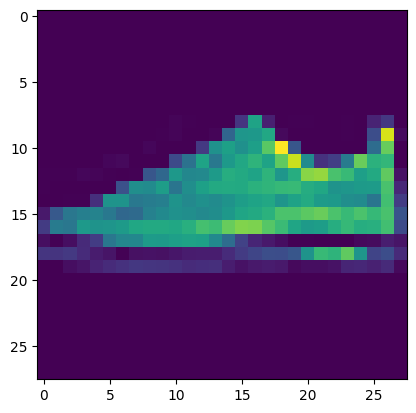

In [66]:
plt.imshow(test_X[0])

In [67]:
train_X_pre_gs = pre_model_2.predict(train_X)
test_X_pre_gs = pre_model_2.predict(test_X)
valid_X_pre_gs = pre_model_2.predict(valid_X)

train_X_vgg16_gs = conv_base.predict(train_X_pre_gs)
test_X_vgg16_gs = conv_base.predict(test_X_pre_gs)
valid_X_vgg16_gs = conv_base.predict(valid_X_pre_gs)


157/157 [==============================] - 26s 165ms/step


In [78]:
d2_model = tf.keras.models.Sequential()

d2_model.add(tf.keras.layers.Input((1, 1, 512)))
d2_model.add(tf.keras.layers.Flatten())
d2_model.add(tf.keras.layers.Dense(128, activation="relu"))
d2_model.add(tf.keras.layers.GaussianNoise(.2))
d2_model.add(tf.keras.layers.Dense(10, activation="softmax"))

d2_model.summary()

d2_model.compile(optimizer=tf.keras.optimizers.RMSprop(), metrics=['categorical_accuracy', 'accuracy', 'categorical_crossentropy'], loss=tf.keras.losses.categorical_crossentropy)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 gaussian_noise_5 (Gaussian  (None, 128)               0         
 Noise)                                                          
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 66954 (261.54 KB)
Trainable params: 66954 (261.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
model_id = "d2"
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=0, patience=20)
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_{model_id}", save_best_only=True, monitor="val_accuracy", mode="max", verbose=0)

history = d2_model.fit(train_X_vgg16_gs, train_Y, batch_size=1000, epochs=200, verbose=0, validation_data=(valid_X_vgg16_gs, valid_Y), callbacks=[callback_save, callback_early_stopping])

INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


INFO:tensorflow:Assets written to: model_d2\assets


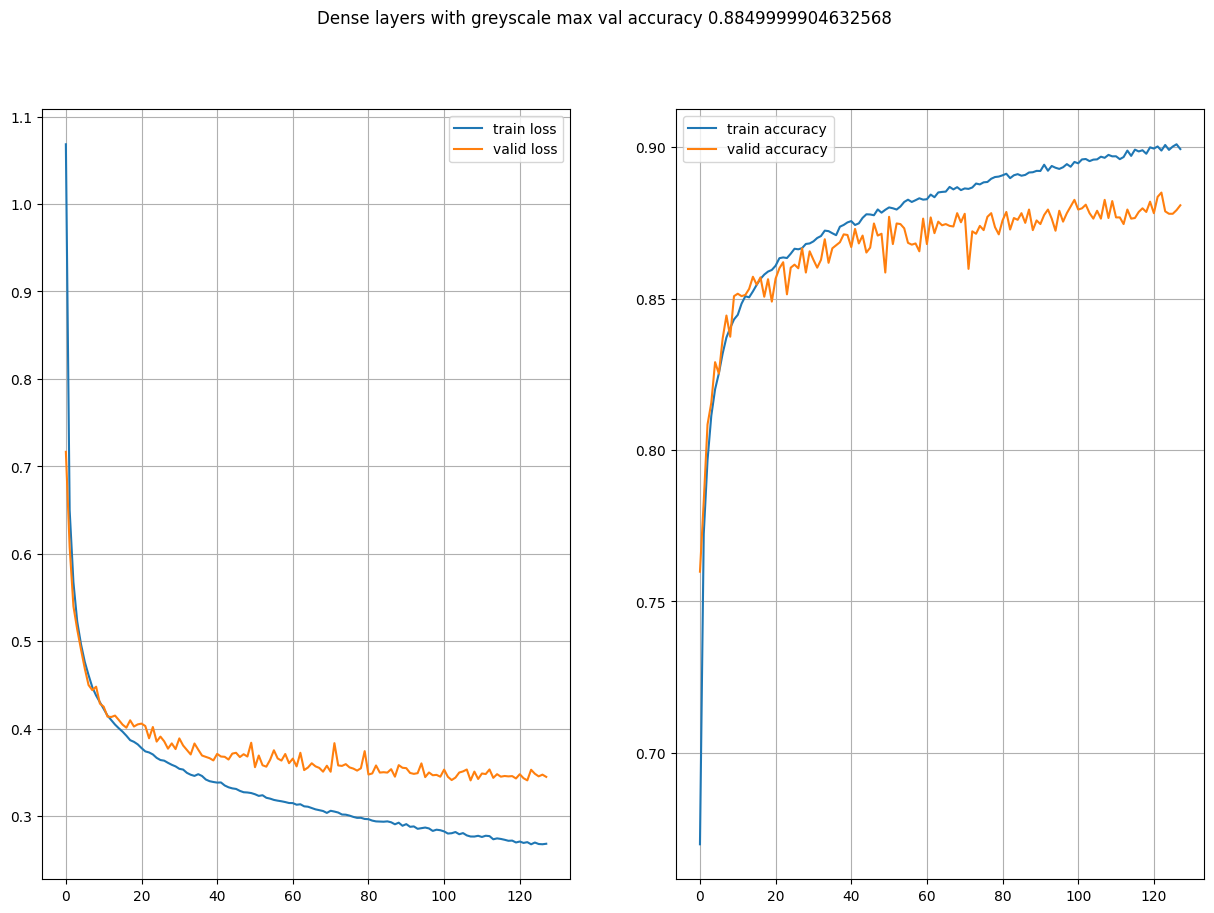

In [80]:
present_histiry("Dense layers with greyscale", history)

Суттєво нічого не змінилось - швидкість класна, результат не дуже. Але півпроцента у цій справі - це півпроцента.

Спробуємо погратись з шарами

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 gaussian_noise_6 (Gaussian  (None, 64)                0         
 Noise)                                                          
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 gaussian_noise_7 (Gaussian  (None, 32)                0         
 Noise)                                                          
                                                                 
 dense_14 (Dense)            (None, 10)              

INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


INFO:tensorflow:Assets written to: model_d2_1\assets


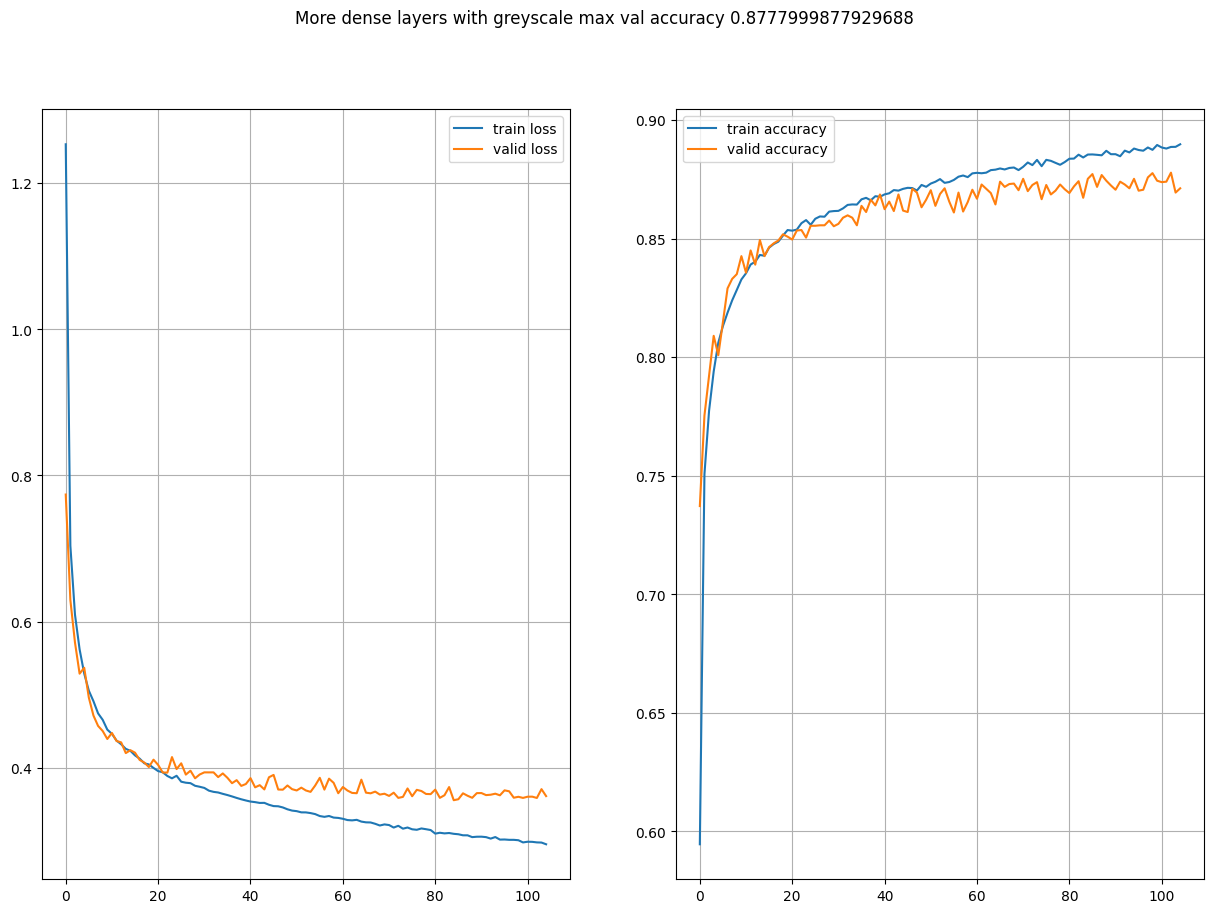

In [81]:
d2_model = tf.keras.models.Sequential()

d2_model.add(tf.keras.layers.Input((1, 1, 512)))
d2_model.add(tf.keras.layers.Flatten())
d2_model.add(tf.keras.layers.Dense(64, activation="relu"))
d2_model.add(tf.keras.layers.GaussianNoise(.2))
d2_model.add(tf.keras.layers.Dense(32, activation="relu"))
d2_model.add(tf.keras.layers.GaussianNoise(.2))
d2_model.add(tf.keras.layers.Dense(10, activation="softmax"))

d2_model.summary()

d2_model.compile(optimizer=tf.keras.optimizers.RMSprop(), metrics=['categorical_accuracy', 'accuracy', 'categorical_crossentropy'], loss=tf.keras.losses.categorical_crossentropy)


model_id = "d2_1"
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=0, patience=20)
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_{model_id}", save_best_only=True, monitor="val_accuracy", mode="max", verbose=0)

history = d2_model.fit(train_X_vgg16_gs, train_Y, batch_size=1000, epochs=200, verbose=0, validation_data=(valid_X_vgg16_gs, valid_Y), callbacks=[callback_save, callback_early_stopping])

present_histiry("More dense layers with greyscale", history)


Гарна спроба, але знову провал: отримана моделька не дотягує навіть до самописної.

На що хотілося б звернути увагу. Ми працювали з пренатренованою моделлю, яку дотягнули до мінімально можливого розміру вхідного зображення 32х32 проти дефолтного розміру 224х224. Як наслідок розмір вихідного вектору (а отже і кількість фіч) дріб'язковий. Що буде, якщо збільшити вхідне зображення?

In [86]:
conv_base2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
conv_base2.trainable = False # Заморозимо

conv_base2.summary()
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [87]:
pre_model_3 = tf.keras.models.Sequential()

pre_model_3.add(tf.keras.layers.Input((28, 28)))
pre_model_3.add(tf.keras.layers.Reshape((1, 28, 28, 1)))
pre_model_3.add(tf.keras.layers.ZeroPadding3D((2, 2, 0), data_format="channels_first"))
pre_model_3.add(tf.keras.layers.UpSampling3D(size=(1, 1, 3), data_format="channels_first"))
pre_model_3.add(tf.keras.layers.Reshape((32, 32, 3)))
pre_model_3.add(tf.keras.layers.Resizing(64, 64))

pre_model_3.summary()

pre_model_3.compile()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 1, 28, 28, 1)      0         
                                                                 
 zero_padding3d_6 (ZeroPadd  (None, 1, 32, 32, 1)      0         
 ing3D)                                                          
                                                                 
 up_sampling3d_4 (UpSamplin  (None, 1, 32, 32, 3)      0         
 g3D)                                                            
                                                                 
 reshape_9 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00

In [88]:
train_X_pre_gs_big = pre_model_3.predict(train_X)
test_X_pre_gs_big = pre_model_3.predict(test_X)
valid_X_pre_gs_big = pre_model_3.predict(valid_X)

train_X_vgg16_gs_big = conv_base2.predict(train_X_pre_gs_big)
test_X_vgg16_gs_big = conv_base2.predict(test_X_pre_gs_big)
valid_X_vgg16_gs_big = conv_base2.predict(valid_X_pre_gs_big)

157/157 [==============================] - 87s 552ms/step


In [92]:
train_X_vgg16_gs_big.shape

(60000, 2, 2, 512)

In [93]:
d3_model = tf.keras.models.Sequential()

d3_model.add(tf.keras.layers.Input((2, 2, 512)))
d3_model.add(tf.keras.layers.Flatten())
d3_model.add(tf.keras.layers.Dense(128, activation="relu"))
d3_model.add(tf.keras.layers.GaussianNoise(.2))
#d2_model.add(tf.keras.layers.Dense(32, activation="relu"))
d3_model.add(tf.keras.layers.GaussianNoise(.2))
d3_model.add(tf.keras.layers.Dense(10, activation="softmax"))

d3_model.summary()



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 128)               262272    
                                                                 
 gaussian_noise_10 (Gaussia  (None, 128)               0         
 nNoise)                                                         
                                                                 
 gaussian_noise_11 (Gaussia  (None, 128)               0         
 nNoise)                                                         
                                                                 
 dense_18 (Dense)            (None, 10)                1290      
                                                                 
Total params: 263562 (1.01 MB)
Trainable params: 2635

INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


INFO:tensorflow:Assets written to: model_d3\assets


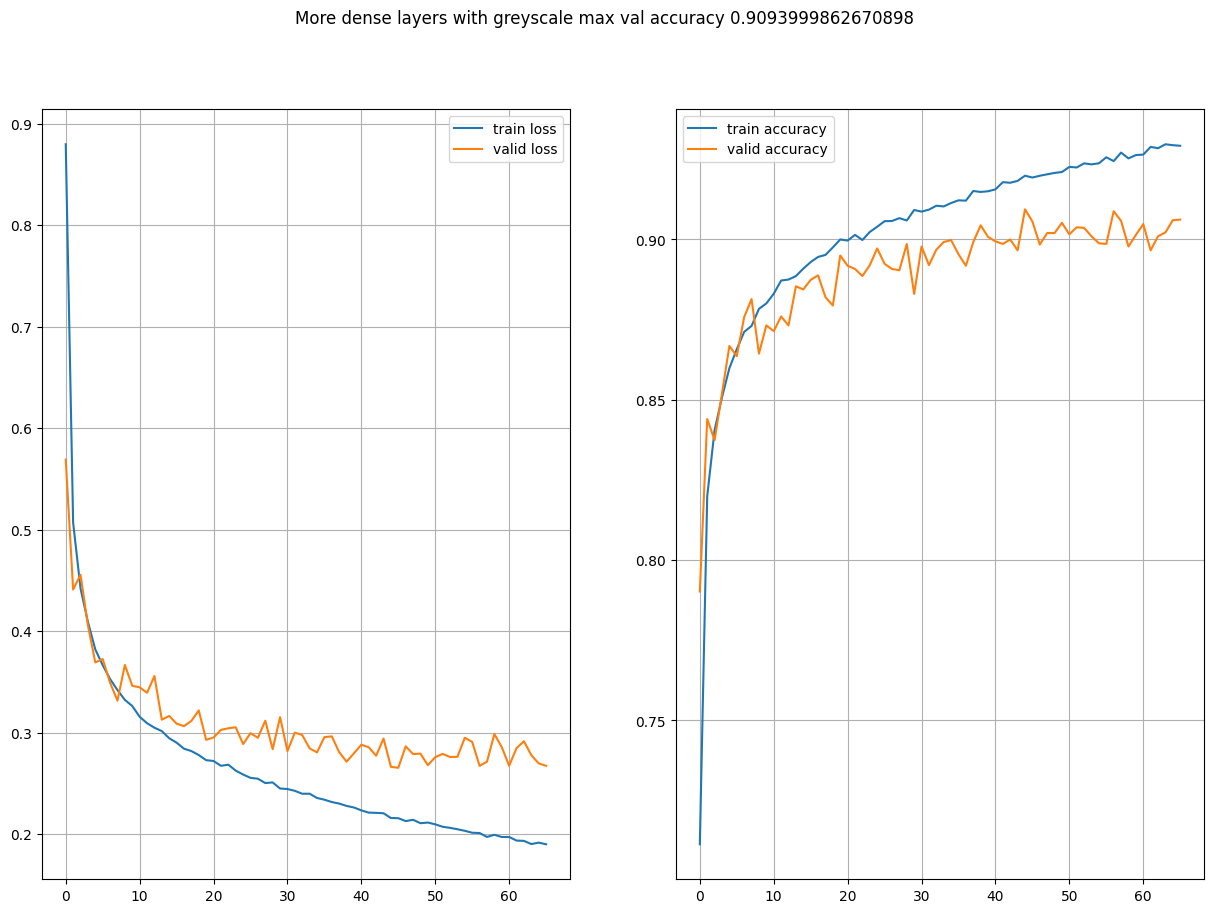

In [94]:
d3_model.compile(optimizer=tf.keras.optimizers.RMSprop(), metrics=['categorical_accuracy', 'accuracy', 'categorical_crossentropy'], loss=tf.keras.losses.categorical_crossentropy)


model_id = "d3"
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=0, patience=20)
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_{model_id}", save_best_only=True, monitor="val_accuracy", mode="max", verbose=0)

history = d3_model.fit(train_X_vgg16_gs_big, train_Y, batch_size=1000, epochs=200, verbose=0, validation_data=(valid_X_vgg16_gs_big, valid_Y), callbacks=[callback_save, callback_early_stopping])

present_histiry("More dense layers with greyscale", history)

ОК, це вже набагато краще. Спробуємо дотягнути розмір зображення до дефолтного.

Поправка. До дефолтного не дотягнемо: або не вистачить ресурсів, щоб підготувати всі дані, або не дочекаємось, поки навчиться модель.

Зупинемось на 128х128

In [7]:
conv_base3 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
conv_base3.trainable = False # Заморозимо

conv_base3.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [9]:
pre_model_4 = tf.keras.models.Sequential()

pre_model_4.add(tf.keras.layers.Input((28, 28)))
pre_model_4.add(tf.keras.layers.Reshape((1, 28, 28, 1)))
pre_model_4.add(tf.keras.layers.ZeroPadding3D((2, 2, 0), data_format="channels_first"))
pre_model_4.add(tf.keras.layers.UpSampling3D(size=(1, 1, 3), data_format="channels_first"))
pre_model_4.add(tf.keras.layers.Reshape((32, 32, 3)))
pre_model_4.add(tf.keras.layers.Resizing(128, 128))

pre_model_4.summary()

pre_model_4.compile()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 1, 28, 28, 1)      0         
                                                                 
 zero_padding3d_1 (ZeroPadd  (None, 1, 32, 32, 1)      0         
 ing3D)                                                          
                                                                 
 up_sampling3d_1 (UpSamplin  (None, 1, 32, 32, 3)      0         
 g3D)                                                            
                                                                 
 reshape_3 (Reshape)         (None, 32, 32, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 

In [10]:
# train_X_pre_gs_huge = pre_model_4.predict(train_X, batch_size=10)
# test_X_pre_gs_huge = pre_model_4.predict(test_X, batch_size=10)
# valid_X_pre_gs_huge = pre_model_4.predict(valid_X, batch_size=10)

# train_X_vgg16_gs_huge = conv_base3.predict(train_X_pre_gs_huge, batch_size=10)
# test_X_vgg16_gs_huge = conv_base3.predict(test_X_pre_gs_huge, batch_size=10)
# valid_X_vgg16_gs_huge = conv_base3.predict(valid_X_pre_gs_huge, batch_size=10)

"""
ResourceExhaustedError    


{
	"name": "ResourceExhaustedError",
	"message": "{{function_node __wrapped__ConcatV2_N_6000_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[60000,128,128,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ConcatV2] name: concat",
	"stack": "---------------------------------------------------------------------------
ResourceExhaustedError                    Traceback (most recent call last)
Cell In[10], line 1
----> 1 train_X_pre_gs_huge = pre_model_4.predict(train_X, batch_size=10)
      2 test_X_pre_gs_huge = pre_model_4.predict(test_X, batch_size=10)
      3 valid_X_pre_gs_huge = pre_model_4.predict(valid_X, batch_size=10)

File c:\\Program Files\\Python39\\lib\\site-packages\\keras\\src\\utils\\traceback_utils.py:70, in filter_traceback.<locals>.error_handler(*args, **kwargs)
     67     filtered_tb = _process_traceback_frames(e.__traceback__)
     68     # To get the full stack trace, call:
     69     # `tf.debugging.disable_traceback_filtering()`
---> 70     raise e.with_traceback(filtered_tb) from None
     71 finally:
     72     del filtered_tb

File c:\\Program Files\\Python39\\lib\\site-packages\\tensorflow\\python\\framework\\ops.py:6656, in raise_from_not_ok_status(e, name)
   6654 def raise_from_not_ok_status(e, name):
   6655   e.message += (\" name: \" + str(name if name is not None else \"\"))
-> 6656   raise core._status_to_exception(e) from None

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_6000_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[60000,128,128,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ConcatV2] name: concat"
}
"""

6000/6000 [==============================] - 36s 6ms/step


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_6000_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[60000,128,128,3] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ConcatV2] name: concat

Ладно, ще трошки пограємось в матрьошки...

In [12]:
pre_full = tf.keras.models.Sequential()

pre_full.add(tf.keras.layers.Input((28, 28)))
pre_full.add(pre_model_4)
pre_full.add(conv_base3)

pre_full.compile()

pre_full.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
train_X_pre_gs_huge = 0
train_X_pre_gs_huge = pre_full.predict(train_X, batch_size=100)

600/600 [==============================] - 4041s 7s/step


In [15]:
test_X_vgg16_gs_huge = pre_full.predict(test_X, batch_size=100)
valid_X_vgg16_gs_huge = pre_full.predict(valid_X, batch_size=100)

50/50 [==============================] - 333s 7s/step


In [16]:
d4_model = tf.keras.models.Sequential()

d4_model.add(tf.keras.layers.Input((4, 4, 512)))
d4_model.add(tf.keras.layers.Flatten())
d4_model.add(tf.keras.layers.Dense(256, activation="relu"))
d4_model.add(tf.keras.layers.GaussianNoise(.2))
#d2_model.add(tf.keras.layers.Dense(32, activation="relu"))
d4_model.add(tf.keras.layers.GaussianNoise(.2))
d4_model.add(tf.keras.layers.Dense(10, activation="softmax"))

d4_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 gaussian_noise_2 (Gaussian  (None, 256)               0         
 Noise)                                                          
                                                                 
 gaussian_noise_3 (Gaussian  (None, 256)               0         
 Noise)                                                          
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2099978 (8.01 MB)
Trainable params: 2099

Epoch 1/200
60/60 [==============================] - ETA: 0s - loss: 1.0521 - categorical_accuracy: 0.7094 - accuracy: 0.7094 - categorical_crossentropy: 1.0521INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 10s 145ms/step - loss: 1.0521 - categorical_accuracy: 0.7094 - accuracy: 0.7094 - categorical_crossentropy: 1.0521 - val_loss: 0.6318 - val_categorical_accuracy: 0.7754 - val_accuracy: 0.7754 - val_categorical_crossentropy: 0.6318
Epoch 2/200
60/60 [==============================] - ETA: 0s - loss: 0.5049 - categorical_accuracy: 0.8206 - accuracy: 0.8206 - categorical_crossentropy: 0.5049INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 118ms/step - loss: 0.5049 - categorical_accuracy: 0.8206 - accuracy: 0.8206 - categorical_crossentropy: 0.5049 - val_loss: 0.4146 - val_categorical_accuracy: 0.8504 - val_accuracy: 0.8504 - val_categorical_crossentropy: 0.4146
Epoch 3/200
60/60 [==============================] - ETA: 0s - loss: 0.4239 - categorical_accuracy: 0.8467 - accuracy: 0.8467 - categorical_crossentropy: 0.4239INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 118ms/step - loss: 0.4239 - categorical_accuracy: 0.8467 - accuracy: 0.8467 - categorical_crossentropy: 0.4239 - val_loss: 0.4002 - val_categorical_accuracy: 0.8516 - val_accuracy: 0.8516 - val_categorical_crossentropy: 0.4002
Epoch 4/200
60/60 [==============================] - 6s 100ms/step - loss: 0.3735 - categorical_accuracy: 0.8631 - accuracy: 0.8631 - categorical_crossentropy: 0.3735 - val_loss: 0.4892 - val_categorical_accuracy: 0.8418 - val_accuracy: 0.8418 - val_categorical_crossentropy: 0.4892
Epoch 5/200
60/60 [==============================] - 7s 113ms/step - loss: 0.3466 - categorical_accuracy: 0.8705 - accuracy: 0.8705 - categorical_crossentropy: 0.3466 - val_loss: 0.4738 - val_categorical_accuracy: 0.8354 - val_accuracy: 0.8354 - val_categorical_crossentropy: 0.4738
Epoch 6/200
60/60 [==============================] - 6s 104ms/step - loss: 0.3246 - categorical_accuracy: 0.8791 - accuracy: 0.8791 - categorical_crossentropy: 0.3

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 8s 141ms/step - loss: 0.3079 - categorical_accuracy: 0.8846 - accuracy: 0.8846 - categorical_crossentropy: 0.3079 - val_loss: 0.3230 - val_categorical_accuracy: 0.8834 - val_accuracy: 0.8834 - val_categorical_crossentropy: 0.3230
Epoch 8/200
60/60 [==============================] - ETA: 0s - loss: 0.2907 - categorical_accuracy: 0.8918 - accuracy: 0.8918 - categorical_crossentropy: 0.2907INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 116ms/step - loss: 0.2907 - categorical_accuracy: 0.8918 - accuracy: 0.8918 - categorical_crossentropy: 0.2907 - val_loss: 0.3091 - val_categorical_accuracy: 0.8852 - val_accuracy: 0.8852 - val_categorical_crossentropy: 0.3091
Epoch 9/200
60/60 [==============================] - ETA: 0s - loss: 0.2824 - categorical_accuracy: 0.8945 - accuracy: 0.8945 - categorical_crossentropy: 0.2824INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 122ms/step - loss: 0.2824 - categorical_accuracy: 0.8945 - accuracy: 0.8945 - categorical_crossentropy: 0.2824 - val_loss: 0.2949 - val_categorical_accuracy: 0.8914 - val_accuracy: 0.8914 - val_categorical_crossentropy: 0.2949
Epoch 10/200
60/60 [==============================] - 6s 98ms/step - loss: 0.2720 - categorical_accuracy: 0.8977 - accuracy: 0.8977 - categorical_crossentropy: 0.2720 - val_loss: 0.2912 - val_categorical_accuracy: 0.8890 - val_accuracy: 0.8890 - val_categorical_crossentropy: 0.2912
Epoch 11/200
60/60 [==============================] - 6s 98ms/step - loss: 0.2634 - categorical_accuracy: 0.9016 - accuracy: 0.9016 - categorical_crossentropy: 0.2634 - val_loss: 0.3235 - val_categorical_accuracy: 0.8802 - val_accuracy: 0.8802 - val_categorical_crossentropy: 0.3235
Epoch 12/200
60/60 [==============================] - 6s 100ms/step - loss: 0.2526 - categorical_accuracy: 0.9061 - accuracy: 0.9061 - categorical_crossentropy: 0.

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 118ms/step - loss: 0.2459 - categorical_accuracy: 0.9076 - accuracy: 0.9076 - categorical_crossentropy: 0.2459 - val_loss: 0.2632 - val_categorical_accuracy: 0.9014 - val_accuracy: 0.9014 - val_categorical_crossentropy: 0.2632
Epoch 14/200
60/60 [==============================] - 6s 106ms/step - loss: 0.2450 - categorical_accuracy: 0.9082 - accuracy: 0.9082 - categorical_crossentropy: 0.2450 - val_loss: 0.2732 - val_categorical_accuracy: 0.8942 - val_accuracy: 0.8942 - val_categorical_crossentropy: 0.2732
Epoch 15/200
60/60 [==============================] - 6s 101ms/step - loss: 0.2341 - categorical_accuracy: 0.9116 - accuracy: 0.9116 - categorical_crossentropy: 0.2341 - val_loss: 0.2783 - val_categorical_accuracy: 0.8960 - val_accuracy: 0.8960 - val_categorical_crossentropy: 0.2783
Epoch 16/200
60/60 [==============================] - 6s 101ms/step - loss: 0.2285 - categorical_accuracy: 0.9138 - accuracy: 0.9138 - categorical_crossentropy: 

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 8s 126ms/step - loss: 0.2148 - categorical_accuracy: 0.9179 - accuracy: 0.9179 - categorical_crossentropy: 0.2148 - val_loss: 0.2577 - val_categorical_accuracy: 0.9058 - val_accuracy: 0.9058 - val_categorical_crossentropy: 0.2577
Epoch 20/200
60/60 [==============================] - 6s 104ms/step - loss: 0.2107 - categorical_accuracy: 0.9194 - accuracy: 0.9194 - categorical_crossentropy: 0.2107 - val_loss: 0.2667 - val_categorical_accuracy: 0.8988 - val_accuracy: 0.8988 - val_categorical_crossentropy: 0.2667
Epoch 21/200
60/60 [==============================] - 6s 101ms/step - loss: 0.2085 - categorical_accuracy: 0.9212 - accuracy: 0.9212 - categorical_crossentropy: 0.2085 - val_loss: 0.2628 - val_categorical_accuracy: 0.9028 - val_accuracy: 0.9028 - val_categorical_crossentropy: 0.2628
Epoch 22/200
60/60 [==============================] - 6s 100ms/step - loss: 0.2035 - categorical_accuracy: 0.9231 - accuracy: 0.9231 - categorical_crossentropy: 

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 123ms/step - loss: 0.1968 - categorical_accuracy: 0.9256 - accuracy: 0.9256 - categorical_crossentropy: 0.1968 - val_loss: 0.2534 - val_categorical_accuracy: 0.9082 - val_accuracy: 0.9082 - val_categorical_crossentropy: 0.2534
Epoch 24/200
60/60 [==============================] - 6s 106ms/step - loss: 0.1964 - categorical_accuracy: 0.9257 - accuracy: 0.9257 - categorical_crossentropy: 0.1964 - val_loss: 0.2477 - val_categorical_accuracy: 0.9082 - val_accuracy: 0.9082 - val_categorical_crossentropy: 0.2477
Epoch 25/200
60/60 [==============================] - 6s 107ms/step - loss: 0.1922 - categorical_accuracy: 0.9273 - accuracy: 0.9273 - categorical_crossentropy: 0.1922 - val_loss: 0.2709 - val_categorical_accuracy: 0.8968 - val_accuracy: 0.8968 - val_categorical_crossentropy: 0.2709
Epoch 26/200
60/60 [==============================] - ETA: 0s - loss: 0.1907 - categorical_accuracy: 0.9269 - accuracy: 0.9269 - categorical_crossentropy: 0.1907

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 8s 126ms/step - loss: 0.1907 - categorical_accuracy: 0.9269 - accuracy: 0.9269 - categorical_crossentropy: 0.1907 - val_loss: 0.2552 - val_categorical_accuracy: 0.9086 - val_accuracy: 0.9086 - val_categorical_crossentropy: 0.2552
Epoch 27/200
60/60 [==============================] - 6s 103ms/step - loss: 0.1855 - categorical_accuracy: 0.9289 - accuracy: 0.9289 - categorical_crossentropy: 0.1855 - val_loss: 0.2578 - val_categorical_accuracy: 0.9070 - val_accuracy: 0.9070 - val_categorical_crossentropy: 0.2578
Epoch 28/200
60/60 [==============================] - 6s 108ms/step - loss: 0.1804 - categorical_accuracy: 0.9307 - accuracy: 0.9307 - categorical_crossentropy: 0.1804 - val_loss: 0.2864 - val_categorical_accuracy: 0.8972 - val_accuracy: 0.8972 - val_categorical_crossentropy: 0.2864
Epoch 29/200
60/60 [==============================] - 6s 101ms/step - loss: 0.1811 - categorical_accuracy: 0.9315 - accuracy: 0.9315 - categorical_crossentropy: 

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 125ms/step - loss: 0.1626 - categorical_accuracy: 0.9379 - accuracy: 0.9379 - categorical_crossentropy: 0.1626 - val_loss: 0.2460 - val_categorical_accuracy: 0.9120 - val_accuracy: 0.9120 - val_categorical_crossentropy: 0.2460
Epoch 37/200
60/60 [==============================] - 6s 102ms/step - loss: 0.1591 - categorical_accuracy: 0.9401 - accuracy: 0.9401 - categorical_crossentropy: 0.1591 - val_loss: 0.2773 - val_categorical_accuracy: 0.8998 - val_accuracy: 0.8998 - val_categorical_crossentropy: 0.2773
Epoch 38/200
60/60 [==============================] - ETA: 0s - loss: 0.1571 - categorical_accuracy: 0.9397 - accuracy: 0.9397 - categorical_crossentropy: 0.1571INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 118ms/step - loss: 0.1571 - categorical_accuracy: 0.9397 - accuracy: 0.9397 - categorical_crossentropy: 0.1571 - val_loss: 0.2344 - val_categorical_accuracy: 0.9166 - val_accuracy: 0.9166 - val_categorical_crossentropy: 0.2344
Epoch 39/200
60/60 [==============================] - 6s 102ms/step - loss: 0.1517 - categorical_accuracy: 0.9430 - accuracy: 0.9430 - categorical_crossentropy: 0.1517 - val_loss: 0.2722 - val_categorical_accuracy: 0.9088 - val_accuracy: 0.9088 - val_categorical_crossentropy: 0.2722
Epoch 40/200
60/60 [==============================] - ETA: 0s - loss: 0.1530 - categorical_accuracy: 0.9421 - accuracy: 0.9421 - categorical_crossentropy: 0.1530INFO:tensorflow:Assets written to: model_d4\assets


INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 8s 127ms/step - loss: 0.1530 - categorical_accuracy: 0.9421 - accuracy: 0.9421 - categorical_crossentropy: 0.1530 - val_loss: 0.2332 - val_categorical_accuracy: 0.9202 - val_accuracy: 0.9202 - val_categorical_crossentropy: 0.2332
Epoch 41/200
60/60 [==============================] - 6s 98ms/step - loss: 0.1480 - categorical_accuracy: 0.9430 - accuracy: 0.9430 - categorical_crossentropy: 0.1480 - val_loss: 0.2593 - val_categorical_accuracy: 0.9116 - val_accuracy: 0.9116 - val_categorical_crossentropy: 0.2593
Epoch 42/200
60/60 [==============================] - 6s 104ms/step - loss: 0.1489 - categorical_accuracy: 0.9435 - accuracy: 0.9435 - categorical_crossentropy: 0.1489 - val_loss: 0.2477 - val_categorical_accuracy: 0.9162 - val_accuracy: 0.9162 - val_categorical_crossentropy: 0.2477
Epoch 43/200
60/60 [==============================] - 6s 93ms/step - loss: 0.1446 - categorical_accuracy: 0.9454 - accuracy: 0.9454 - categorical_crossentropy: 0.

INFO:tensorflow:Assets written to: model_d4\assets


60/60 [==============================] - 7s 119ms/step - loss: 0.1101 - categorical_accuracy: 0.9577 - accuracy: 0.9577 - categorical_crossentropy: 0.1101 - val_loss: 0.2471 - val_categorical_accuracy: 0.9230 - val_accuracy: 0.9230 - val_categorical_crossentropy: 0.2471
Epoch 65/200
60/60 [==============================] - 5s 85ms/step - loss: 0.1083 - categorical_accuracy: 0.9589 - accuracy: 0.9589 - categorical_crossentropy: 0.1083 - val_loss: 0.2702 - val_categorical_accuracy: 0.9178 - val_accuracy: 0.9178 - val_categorical_crossentropy: 0.2702


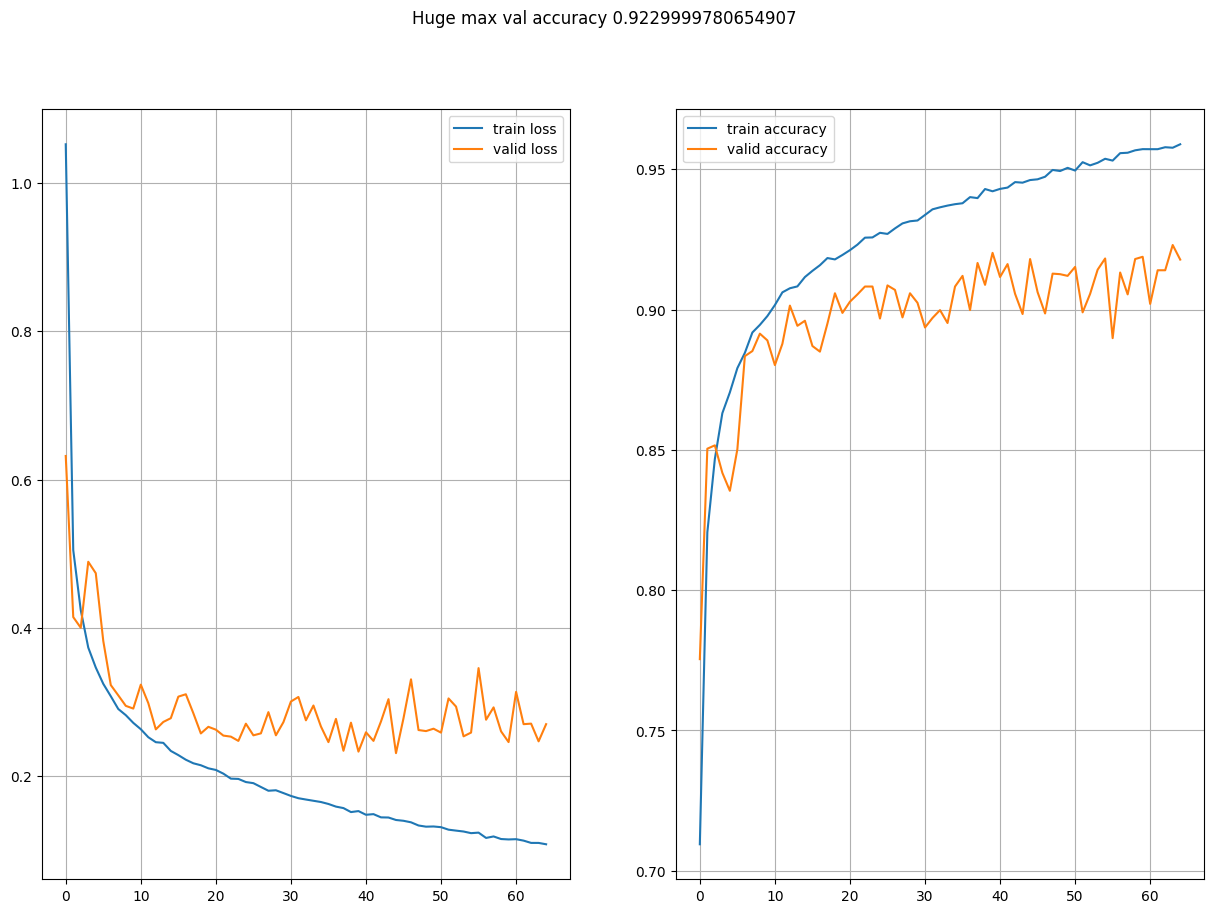

In [17]:
d4_model.compile(optimizer=tf.keras.optimizers.RMSprop(), metrics=['categorical_accuracy', 'accuracy', 'categorical_crossentropy'], loss=tf.keras.losses.categorical_crossentropy)


model_id = "d4"
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_crossentropy", mode="min", verbose=0, patience=20)
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_{model_id}", save_best_only=True, monitor="val_accuracy", mode="max", verbose=0)

history = d4_model.fit(train_X_pre_gs_huge, train_Y, batch_size=1000, epochs=200, verbose=1, validation_data=(valid_X_vgg16_gs_huge, valid_Y), callbacks=[callback_save, callback_early_stopping])

present_histiry("Huge", history)

Ну а це вже схоже на результат. Відновимо повнозв'язану модель з найкращими параметрами, зберемо все до купи та оцінимо.

In [20]:
dense_model = tf.keras.saving.load_model("model_d4")
dense_model.trainable = False

full_model = tf.keras.models.Sequential()

full_model.add(tf.keras.layers.Input((28, 28)))
full_model.add(pre_full)
full_model.add(dense_model)

full_model.compile(metrics=['categorical_accuracy', 'accuracy', 'categorical_crossentropy'])

full_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 4, 4, 512)         14714688  
                                                                 
 sequential_5 (Sequential)   (None, 10)                2099978   
                                                                 
Total params: 16814666 (64.14 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 16814666 (64.14 MB)
_________________________________________________________________


In [21]:
full_model.evaluate(test_X, test_Y)

157/157 [==============================] - 326s 2s/step - loss: 0.0000e+00 - categorical_accuracy: 0.9184 - accuracy: 0.9184 - categorical_crossentropy: 0.2406


[0.0, 0.91839998960495, 0.91839998960495, 0.24061445891857147]

На тестових даних отриманий франкенштейн показує точність у майже 92%. 

Замість висновків.

1. Попередньо треновану модель треба обирати якомога ближче до формату даних конкретної задачі. В нашому випадку, на мою думку, розмір зображень був замалий для використаної моделі, ситуацію виправило тільки збільшення зображень.
2. Фокус з перенесенням попередньо натренованої моделі у фактично розділ препроцесингу вважаю вдалим, адже всі операції по обробці вхідного датасету виконувались тільки один раз, а не кожної епохи. Якщо говорити за останню модель, то вона могла б тренуватись годин 60-80, а не 7 хвилин.
3. Попередньо натреновані моделі треба вишукувати і акуратно зберігати, повторити самотужки результат токої моделі буде важко.
4. І вкотре: складніша модель не завжди відповідає кращому результату.